<a href="https://colab.research.google.com/github/mydmitrii/DS_projects/blob/main/Drug%20Review_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ отзывов на лекарства

# Загрузка и первичное исследование данных

In [ ]:
# импорт библиотек

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, r2_score
import nltk
import nltk
from textblob import Word
from nltk.corpus import stopwords
from math import sqrt
from sklearn.model_selection import train_test_split

# модули библиотеки PyTorch
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn import MSELoss

# модуль, где определены слои для нейронных сетей
import torch.nn as nn
# модуль, где определены активации для слоев нейронных сетей
import torch.nn.functional as F


Загрузим датасет через kaggle api

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 63 bytes


In [ ]:
!kaggle datasets download -d jessicali9530/kuc-hackathon-winter-2018

 81% 33.0M/40.7M [00:00<00:00, 81.0MB/s]
100% 40.7M/40.7M [00:00<00:00, 70.6MB/s]


In [ ]:
!unzip kuc-hackathon-winter-2018.zip

Archive:  kuc-hackathon-winter-2018.zip
  inflating: drugsComTest_raw.csv    
  inflating: drugsComTrain_raw.csv   


In [ ]:
train_path = "/content/drugsComTrain_raw.csv"
val_path = "/content/drugsComTest_raw.csv"

In [ ]:
# Считываем данные
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(val_path)

# Первичное исследование данных

In [ ]:
train_df.head() #первые 5 строк датасета

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [ ]:
test_df.head() #первые 5 строк датасета

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [ ]:
#кол-во строк и столбцов
print('train_df size is:', train_df.shape)
print('test_df size is:', test_df.shape)

train_df size is: (161297, 7)
test_df size is: (53766, 7)


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   uniqueID     161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [ ]:
train_df.columns #список признаков

Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')

In [ ]:
train_df.isnull().sum() #проверка на пропуски

uniqueID         0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

Пропуски есть в строке condition, т.к.в наших задачах данный признак не используется, можем пропуски не удалять

In [ ]:
train_df[train_df.duplicated()] #проверим наличие дубликатов

,uniqueID,drugName,condition,review,rating,date,usefulCount


Видим, что в датасете отсутствуют дубликаты и поэтому нет необходимости в команде drop_duplicates

In [ ]:
train_df.describe()

,uniqueID,rating,usefulCount
count,161297.000000,161297.000000,161297.000000
mean,115923.585305,6.994377,28.004755
std,67004.445170,3.272329,36.403742
min,2.000000,1.000000,0.000000
25%,58063.000000,5.000000,6.000000
50%,115744.000000,8.000000,16.000000
75%,173776.000000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [ ]:
train_df['review'] #посмотрим на некоторые из обзоров

0         "It has no side effect, I take it in combinati...
1         "My son is halfway through his fourth week of ...
2         "I used to take another oral contraceptive, wh...
3         "This is my first time using any form of birth...
4         "Suboxone has completely turned my life around...
                                ...                        
161292    "I wrote my first report in Mid-October of 201...
161293    "I was given this in IV before surgey. I immed...
161294    "Limited improvement after 4 months, developed...
161295    "I&#039;ve been on thyroid medication 49 years...
161296    "I&#039;ve had chronic constipation all my adu...
Name: review, Length: 161297, dtype: object

Удалим неинформативные для нас признаки: "uniqueID", "date"

In [ ]:
train_df.drop(['uniqueID', 'date'], axis=1, inplace=True)

In [ ]:
train_df.head(10) #посмотрим на датасет

,drugName,condition,review,rating,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,37
5,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,43
6,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,5
7,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,32
8,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,11
9,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,1


Повторим аналогичные действия для тестового датасета

In [ ]:
test_df.isnull().sum() #проверка на пропуски

uniqueID         0
drugName         0
condition      295
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [ ]:
test_df[test_df.duplicated()] #проверим наличие дубликатов

,uniqueID,drugName,condition,review,rating,date,usefulCount


Видим, что в датасете отсутствуют дубликаты и поэтому нет необходимости в команде drop_duplicates

In [ ]:
test_df.drop(['uniqueID', 'date'], axis=1, inplace=True) #удалим неинформативные признаки

In [ ]:
test_df.head(10) #посмотрим на датасет

,drugName,condition,review,rating,usefulCount
0,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,22
1,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17
2,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,3
3,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,35
4,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,4
5,Zyclara,Keratosis,"""4 days in on first 2 weeks. Using on arms an...",4,13
6,Copper,Birth Control,"""I&#039;ve had the copper coil for about 3 mon...",6,1
7,Amitriptyline,Migraine Prevention,"""This has been great for me. I&#039;ve been on...",9,32
8,Methadone,Opiate Withdrawal,"""Ive been on Methadone for over ten years and ...",7,21
9,Levora,Birth Control,"""I was on this pill for almost two years. It d...",2,3


# EDA. Разведочный анализ данных

Выведем число обзоров в зависимости от заболевания/категории лекарственного препарата для 10 самых популярных видов

In [ ]:
conditions = train_df.condition.value_counts().sort_values(ascending=False)
conditions[:20]

Birth Control                28788
Depression                    9069
Pain                          6145
Anxiety                       5904
Acne                          5588
Bipolar Disorde               4224
Insomnia                      3673
Weight Loss                   3609
Obesity                       3568
ADHD                          3383
Diabetes, Type 2              2554
Emergency Contraception       2463
High Blood Pressure           2321
Vaginal Yeast Infection       2274
Abnormal Uterine Bleeding     2096
Bowel Preparation             1859
ibromyalgia                   1791
Smoking Cessation             1780
Migraine                      1694
Anxiety and Stress            1663
Name: condition, dtype: int64

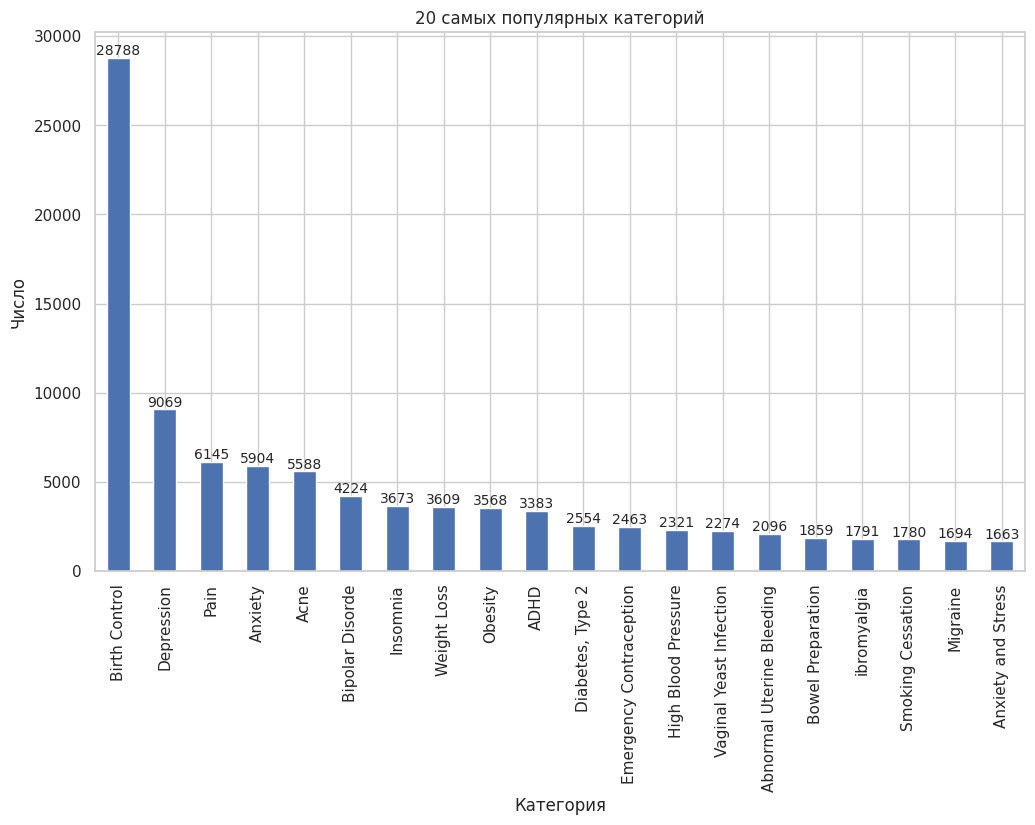

In [ ]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(12,7))
conditions[:20].plot(kind='bar')
plt.title('20 самых популярных категорий')
plt.xlabel('Категория')
plt.ylabel('Число')

# Получаем значения столбцов
values = conditions[:20].values

# Добавляем значения на график
for i, value in enumerate(values):
    plt.text(i, value, str(value), ha='center', va='bottom', size = 10)


plt.show()

Посмотрим на распределение оценок

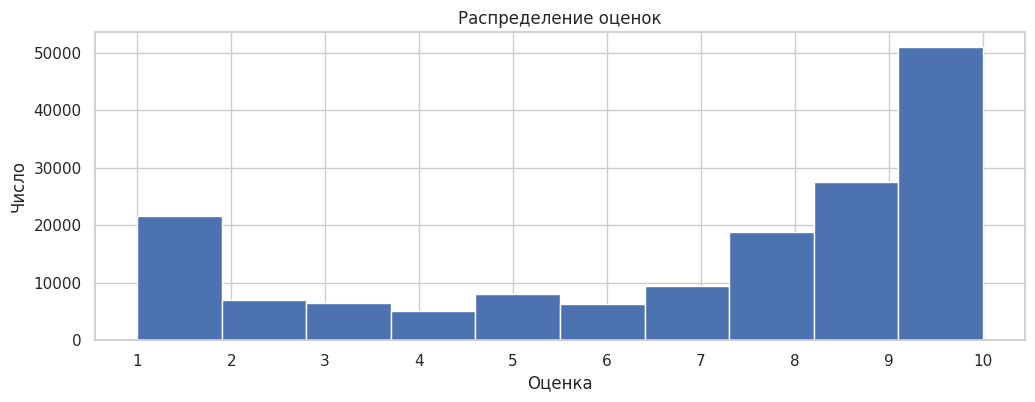

In [ ]:
plt.figure(figsize=(12,4))

train_df.rating.hist()
plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Число')
plt.xticks([i for i in range(1, 11)]);

Видим, что большинство оценок принимают крайние значения: 1 или 9-10

Посмотрим на зависимость полезности от оценки

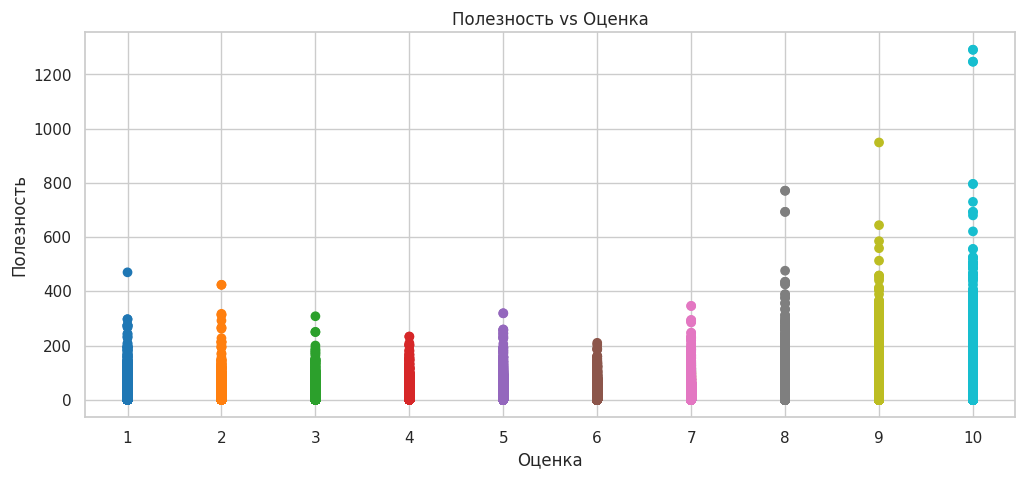

In [ ]:
plt.figure(figsize=(12,5))

plt.scatter(train_df.rating, train_df.usefulCount, c=train_df.rating.values, cmap='tab10')
plt.title('Полезность vs Оценка')
plt.xlabel('Оценка')
plt.ylabel('Полезность')
plt.xticks([i for i in range(1, 11)]);

Видим, что полезность коррелирует с итоговой оценкой

Выведем топ 20 лекарств с лучшим рейтингом

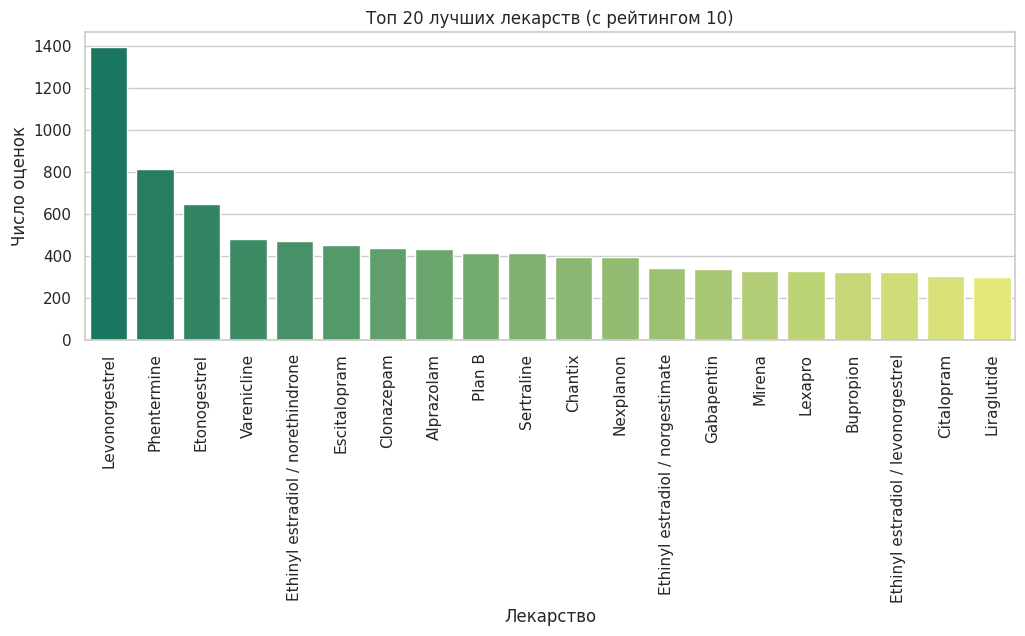

In [ ]:
plt.figure(figsize=(12,4))

rating = dict(train_df.loc[train_df.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'summer')

sns_rating.set(title = 'Топ 20 лучших лекарств (c рейтингом 10)', ylabel = 'Число оценок', xlabel = "Лекарство")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

Выведем топ 20 лекарств с худшим рейтингом

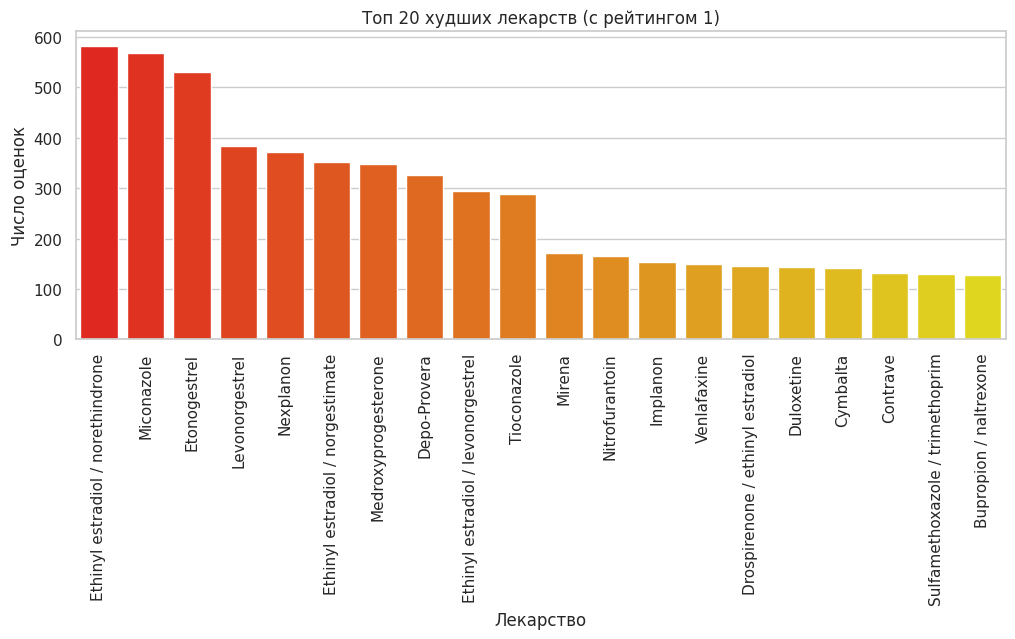

In [ ]:
plt.figure(figsize=(12,4))

rating = dict(train_df.loc[train_df.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'autumn')

sns_rating.set(title = 'Топ 20 худших лекарств (с рейтингом 1)', ylabel = 'Число оценок', xlabel = "Лекарство")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

Выведем рецензии на несколько лекарств с лучшей полезностью и оценкой 10

In [ ]:
useful_train = train_df[train_df.rating == 10].sort_values(by='usefulCount', ascending=False)
useful_train.iloc[:5]

,drugName,condition,review,rating,usefulCount
6716,Sertraline,Depression,"""I remember reading people&#039;s opinions, on...",10,1291
33552,Zoloft,Depression,"""I remember reading people&#039;s opinions, on...",10,1291
4249,Mirena,Birth Control,"""I have had my IUD for over a year now and I t...",10,1247
21708,Levonorgestrel,Birth Control,"""I have had my IUD for over a year now and I t...",10,1247
16889,Adipex-P,Weight Loss,"""I have used this pill off and on for the past...",10,796


In [ ]:
for i in useful_train.review.iloc[:5]:
    print(i, '\n')  #выведем отзывы

"I remember reading people&#039;s opinions, online, of the drug before I took it and it scared me away from it. Then I finally decided to give it a try and it has been the best choice I have made. I have been on it for over 4 months and I feel great. I&#039;m on 100mg and I don&#039;t have any side effects. When I first started I did notice that my hands would tremble but then it subsided. So honestly, don&#039;t listen to all the negativity because what doesn&#039;t work for some works amazing for others. So go based on youself and not everyone else. It may be a blessing in diguise. The pill is not meant to make you be all happy go lucky and see &quot;butterflies and roses&quot;, its meant to help put the chemicals in your mind in balance so you can just be who you are and not overly depressed. I still get sad some times, but that is normal, that is life, and it&#039;s up to people to take control to make a change. I did so by getting on this pill." 

"I remember reading people&#039;s

Выведем рецензии на несколько лекарств с оценкой 1

In [ ]:
useless_train = train_df[train_df.rating == 1]
useless_train.iloc[:5]

,drugName,condition,review,rating,usefulCount
6,Levonorgestrel,Emergency Contraception,"""He pulled out, but he cummed a bit in me. I t...",1,5
8,Keppra,Epilepsy,""" I Ve had nothing but problems with the Kepp...",1,11
24,Tioconazole,Vaginal Yeast Infection,"""Do not use the cream that comes with this. It...",1,7
33,Tioconazole,Vaginal Yeast Infection,"""The burning is out of control about 20 minute...",1,2
36,Dulcolax,Constipation,"""SO MUCH PAIN! \r\nIn the last 2 years I have ...",1,10


In [ ]:
for i in useless_train.review.iloc[:5]:
    print(i, '\n')  #выведем отзывы

"He pulled out, but he cummed a bit in me. I took the Plan B 26 hours later, and took a pregnancy test two weeks later - - I&#039;m pregnant." 

" I Ve had  nothing but problems with the Keppera : constant shaking in my arms &amp; legs &amp; pins &amp; needles feeling in my arms &amp; legs severe light headedness no appetite &amp; etc." 

"Do not use the cream that comes with this. It turned my hoo-ha into a burning ring of fire. It is 1 am and I have to work tomorrow. It&#039;s going to be a sleepless night for me" 

"The burning is out of control about 20 minutes after inserting it . Sat in the bath trying to get this stuff out . This is awful" 

"SO MUCH PAIN! 
In the last 2 years I have suffered with a brain tumour so have been in a LOT of pain to the point of morphine everyday for a year. Then I had brain surgery...but the pain from this pill came pretty close!! In serious pain to the point of blacking out hot and cold shivers and just sat in pain feeling like trapped wind/indiges

По этим негативным отзывам можно сделать выводы, что лекарства либо не работают, либо имеют ужасные последствия и такая низкая оценка справедлива

# Подготовка данных

In [ ]:
# Подготовка данных
sentences = train_df.review.values
labels = train_df.rating.values

In [ ]:
print(sentences[1000]) #выведем одно из них
print(labels[1000]) #выведем рейтинг для него

"I used Voltaren gel on some sore joints (and a tennis elbow). It worked as well as anything I have ever tried. I sometimes get killer tension headaches that first build up in the back of the neck.  When I felt one coming on, I used the gel on the back of the neck and shoulders.  The headache never developed.  Before this experiment I would take 3 or 4 ibuprofen for one of these headaches and hope for the best.  The gel is now my standard treatment for these headaches."
9


In [ ]:
assert len(sentences) == len(labels) # проверка, числа предложений и оценок

# Токенизация

Импортируем токенизатор для BERT'а, который превратит наши тексты в набор токенов, соответствующих тем, что встречаются в словаре предобученной модели.

In [ ]:
!pip install transformers

  Using cached transformers-4.30.2-py3-none-any.whl (7.2 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.9 MB/s eta 0:00:00


In [ ]:
!pip install -qq Keras-Preprocessing

In [ ]:
#библиотека для обрезания токенов
from keras_preprocessing.sequence import pad_sequences

In [ ]:
from transformers import AdamW, DistilBertForSequenceClassification, DistilBertTokenizer

# используем предобученный токенизатор от BERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', do_lower_case=True)


In [ ]:
train_df['review']

0         "It has no side effect, I take it in combinati...
1         "My son is halfway through his fourth week of ...
2         "I used to take another oral contraceptive, wh...
3         "This is my first time using any form of birth...
4         "Suboxone has completely turned my life around...
                                ...                        
161292    "I wrote my first report in Mid-October of 201...
161293    "I was given this in IV before surgey. I immed...
161294    "Limited improvement after 4 months, developed...
161295    "I&#039;ve been on thyroid medication 49 years...
161296    "I&#039;ve had chronic constipation all my adu...
Name: review, Length: 161297, dtype: object

<Axes: >

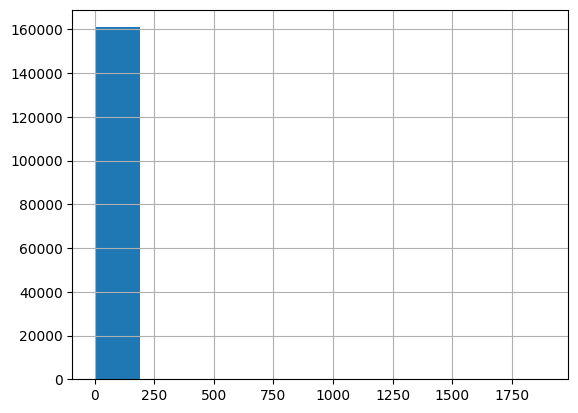

In [ ]:
#найдем среднюю длину предложений в датасете трейн
train_df['review'].map(lambda x: len(x.split())).hist()

Видим, что большая часть предложений имеет до 200 символов. Будем использовать данное значение для параметра "maxlen"

In [ ]:
#преобразуем токены в их числовые идентификаторы

input_ids = [tokenizer.encode(sent, add_special_tokens=True) for sent in sentences] #добавим специальные токены [CLS] и [SEP]
input_ids = pad_sequences(input_ids, maxlen=200, #ограничим максимальную длину 200 токенами, согласно гистограмме
                          dtype="long", truncating="post", padding="post")

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Token indices sequence length is longer than the specified maximum sequence length for this model (550 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
input_ids

array([[ 101, 1000, 2009, ...,    0,    0,    0],
       [ 101, 1000, 2026, ...,    0,    0,    0],
       [ 101, 1000, 1045, ...,    0,    0,    0],
       ...,
       [ 101, 1000, 3132, ...,    0,    0,    0],
       [ 101, 1000, 1045, ...,    0,    0,    0],
       [ 101, 1000, 1045, ...,    0,    0,    0]])

Делим данные на train и val:

In [ ]:
# Разделим данные на обучающую и тестовую выборки
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels,
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)


Преобразуем данные в pytorch тензоры:

In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)

In [ ]:
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train_labels #выведем оценки рейтинга

tensor([10,  9, 10,  ...,  6,  7,  1])

Воспользуемся классом DataLoader. Это поможет нам использовать эффективнее память во время тренировки модели, так как нам не нужно будет загружать в память весь датасет. Данные по батчам будем разбивать произвольно с помощью RandomSampler.

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)

train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=128
)

In [ ]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)

validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=128
)

# Обучение модели

Возьмем готовую модификацию BERTа для классификации из pytorch-transformers -  BertForSequenceClassification. Это обычный BERT с добавленным линейным слоем для классификации.

In [ ]:
from transformers import AdamW, BertForSequenceClassification

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()

0

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name()

'NVIDIA A100-SXM4-40GB'

In [ ]:
#используем модель bert-base-uncased
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=1) #на выходе для регрессии используем 1 значение
model.to(device)


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.we

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

Подберем гиперпараметры для обучения нашей модели. Дообучим нашу модель всего за одну эпоху

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


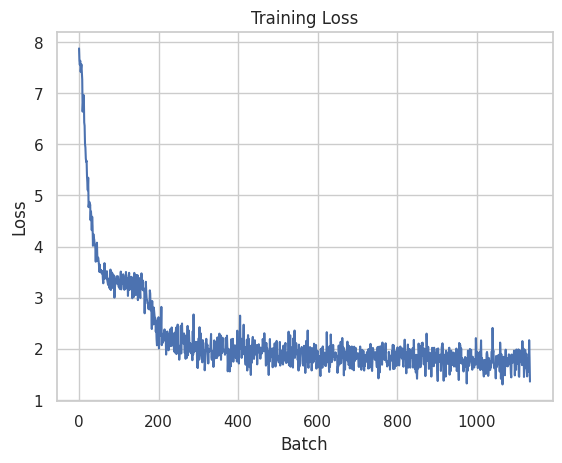

Loss на обучающей выборке: 2.20468
RMSE на валидационной выборке: 1.74


In [ ]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()


for step, batch in enumerate(train_dataloader):
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Преобразуем метки в float
    b_labels = b_labels.float()

    # если не сделать .zero_grad(), градиенты будут накапливаться
    optimizer.zero_grad()

    # Forward pass
    outputs = model(b_input_ids, attention_mask=b_input_mask)
    loss = torch.sqrt(((b_labels-outputs.logits.squeeze())**2).mean())  # Использование RMSE как функции потерь

    train_loss_set.append(loss.item())

    # Backward pass
    loss.backward()

    # Обновляем параметры и делаем шаг используя посчитанные градиенты
    optimizer.step()

    # Обновляем loss
    train_loss += loss.item()

    # Рисуем график
    clear_output(True)
    plt.plot(train_loss_set)
    plt.title("Training Loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.show()

print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))

# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)

    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Преобразуем метки в float
    b_labels = b_labels.float()

    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    valid_preds.extend(logits)
    valid_labels.extend(label_ids)


valid_preds = np.array(valid_preds)
valid_labels = np.array(valid_labels)

print("RMSE на валидационной выборке: {0:.2f}".format(
    np.sqrt(mean_squared_error(valid_labels, valid_preds))
))

Для оценки валидационной выборки будем использовать среднеквадратичную ошибку (RMSE)

In [ ]:
print("RMSE на валидационной выборке: {0:.2f}".format(
    np.sqrt(mean_squared_error(valid_labels, valid_preds))
))

RMSE на валидационной выборке: 1.74


Ошибка в 1.74 говорит о том, что прогнозируемая оценка рейтинга может отклоняться от истинного значения в пределах 1.74, что для диапазона оценок рейтинга от 1 до 10 можно считать приемлемым значением

# Оценка качества на отложенной выборке

Делаем точно такую же предобработку для тестовых данных, как и в начале ноутбука делали для обучающих данных:

In [ ]:
# Подготовка данных
test_sentences = test_df.review.values
test_labels = test_df.rating.values

In [ ]:
assert len(test_sentences) == len(test_labels) # проверка, числа предложений и оценок

In [ ]:
#преобразуем токены в их числовые идентификаторы

input_ids = [tokenizer.encode(sent, add_special_tokens=True) for sent in test_sentences] #добавим специальные токены [CLS] и [SEP]
input_ids = pad_sequences(input_ids, maxlen=200, #ограничим максимальную длину 200 токенами, согласно гистограмме
                          dtype="long", truncating="post", padding="post")

attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Приводим данные в необходимый формат:

In [ ]:
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_labels)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data,
    sampler=SequentialSampler(prediction_data),
    batch_size=128
)


In [ ]:
from tqdm.auto import tqdm
model.eval()
test_preds, test_labels = [], []

for batch in tqdm(prediction_dataloader):
    batch = tuple(t.to(device) for t in batch)

    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask)

    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    test_preds.extend(logits)
    test_labels.extend(label_ids)

test_preds = np.array(test_preds)
test_labels = np.array(test_labels)

print("RMSE на тестовой выборке: {0:.2f}".format(
    np.sqrt(mean_squared_error(test_labels, test_preds))
))

  0%|          | 0/421 [00:00<?, ?it/s]

RMSE на тестовой выборке: 1.73


Ошибка в 1.73 на отложенной выборке близка к оценке валидационной выборки и говорит о том, что прогнозируемая оценка рейтинга может отклоняться от истинного значения в пределах 1.73, что для диапазона оценок рейтинга от 1 до 10 можно считать приемлемым значением

# Тематическое моделирование кластеров текстов в колонке review

Смоделируем кластеры для части тестового датасета, т.к. эмбеддинги считаются очень долго

In [ ]:
test = test_df[:1000]

In [ ]:
# загрузим библиотеки
!pip install umap-learn
!pip install hdbscan

import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=1ee99ebe905c94fc5fbc9c7b41433f3c7e51d62e7e631e17e3a5124977aab1c8
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=3f0021e5a3cf563225a86434022bbef9b452c30c49dd046bcc269d2c71feeb39
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 52.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metad

In [ ]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
from transformers import AutoTokenizer, AutoModel

# Загрузка модели и токенизатора
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# Разобьем предложения на батчи по 256
# Вычислим эмбеддинги для каждого батча и объединим вместе

def get_embeddings(sentences, model, tokenizer, batch_size=256):
    embeddings = []

    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        encoded_input = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors='pt')

        with torch.no_grad():
            model_output = model(**encoded_input)

        sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        embeddings.append(sentence_embeddings)

    embeddings = torch.cat(embeddings)
    return embeddings

sentences = test['review'].tolist()
sentence_embeddings = get_embeddings(sentences, model, tokenizer)

In [ ]:
# Приводим в нужный формат
embeddings = sentence_embeddings.detach().numpy()

# Выполняем уменьшение размерности с помощью UMAP
umap_embeddings = umap.UMAP(n_neighbors=15,
                            n_components=2,
                            min_dist=0.0,
                            metric='cosine').fit_transform(embeddings)

# Выполняем кластеризацию с помощью HDBSCAN
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',
                          cluster_selection_method='eom').fit(umap_embeddings)


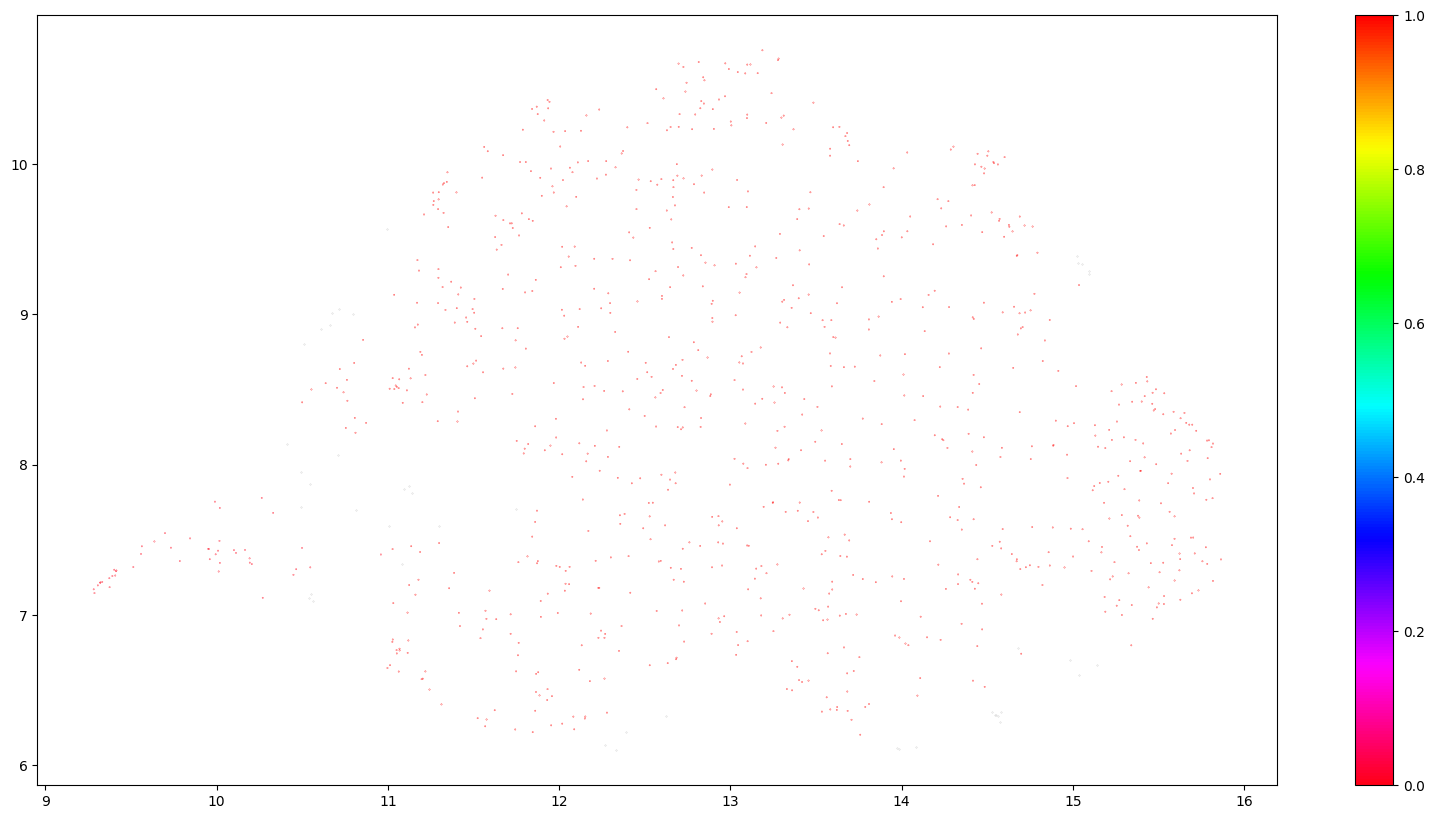

In [ ]:
# Создаем DataFrame из результатов UMAP и меток кластеров.
result = pd.DataFrame(umap_embeddings, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Создаем новую фигуру для визуализации
fig, ax = plt.subplots(figsize=(20, 10))

# Визуализируем результаты.
# Мы разделим точки на две группы: "выбросы" (те, что были помечены как -1) и "кластеризованные" (все остальные)
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

# Теперь создаем диаграмму рассеяния (scatter plot). Выбросы окрашиваем в серый цвет, а кластеры - в разные цвета в зависимости от метки кластера.
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')

# Добавляем colorbar для понимания, какие цвета соответствуют каким кластерам.
plt.colorbar()

# Отображаем график
plt.show()